In [5]:
#############################
### Import libraries ###
#############################

from docplex.cp.model import *
from docplex.cp.config import get_default
import numpy as np
from Solver import *
from User import *
import time

In [6]:
#############################
### Essentials functions ###
#############################
import FunctionMain as fm
import clustering as cl

In [7]:
# ----------------- Parameters

# The file to consider
file = './file_with_optimal_val/la04.txt'

# The number of solutions that we will have in the solver during the first iteration
k = 20

# The number of layer which is fixed
nb_layers = 5

# Variable which display the solution
display_sol = False

# Variable which display the start (in a vector)
display_start = False

# Variable which display the start (in a matrix)
display_matrix = False

# Time stop criterion 
tps_max = 300

# Number of iteration stop criterion
it_max = 30




# The number of solutions that we will have in the solver after the first iteration
k_k = 15

list_search_type = ["DepthFirst", "Restart", "MultiPoint", "IterativeDiving"]

In [8]:
#############################
### Main program ###
#############################

print("\n--------Main program is loading...---------")

# --------- Interaction with the solver
data = []
n, m, data, T_machine, T_duration, duration, optimalval = fm.get_data_from_file(file)

# --------- Call Solver constructor in Solver.py and create the variables of the model
model, solver, starts = fm.initialize_solver(data, n, m, duration)

# ------------ Solve the model
print("\nSolving the model...")
msol, nb_solution, runtime = solver.solve(model, k, n, m, T_machine, optimalval, tps_max, it_max)

# ------------ Display the result
fm.display_solution(msol, display_sol)
print("Model solved !")

# ---------------- Interaction with the user
print("\n--------Interaction with the user...---------")
print("\nCreating the user...")
user = User()
print("User created !")

#Get the variables of the model
variables = solver.get_variables()

list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)

# Vector of the start time of each task of each preference
starts = user.start_pref(n, m, display_start)

# Matrix of the start time of each task of each preference
matrix = user.matrix_pref(n, m, display_matrix)

# Testing the order of preferences and the differences between solutions
fm.test(n, m, user)

print("list layers : ",list_layers)



--------Main program is loading...---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
Model solved !

--------Interaction with the user...---------

Creating the user...
User created !

Classing solutions...
Le min de list_obj est 2330208
Le max de list_obj est 3567960
Solutions classed !

Creating preferences...
Preferences created !

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes
list layers :  [[<docplex.cp.solution.CpoSolveResult object at 0x000001D83D1E2640>, <docplex.cp.solution.CpoSolveResult object at 0x000001D84BEBB540>, <docplex.cp.solution.CpoSolveResult object at 0x000001D8441D1F40>], [<docplex.cp.solution.CpoSolveResult object at 0x000001D849

In [9]:
####################################################################
#### Exploration: RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
it = 1
tps = runtime
list_min_obj = [min(list_obj)]
list_min_obj_global = [min(list_obj)]

criterion = (tps < tps_max/2) and (it < it_max/2) 

# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # # --------- Add the constraints considering the clustering
    
    list_rayon_layers, list_start_sol_layers, dict_sol_rayon  = fm.list_rayon_binaire_cluster(n, m, list_layers)
    list_rayon_layers_flatten = [item for sublist in list_rayon_layers[1:] for item in sublist]
    list_start_sol_layers_flatten = [item for sublist in list_start_sol_layers[1:] for item in sublist]
         
    for l in range(len(list_rayon_layers_flatten)):
        solver.add_constraint(model, fm.manhattan_binaire_distance_contrainte(list_start_sol_layers_flatten[l], [model.start_of(variables[i//m][i%m]) for i in range(n*m)]) > list_rayon_layers_flatten[l])
               
            

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, T_machine, optimalval, tps_max, it_max)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max/2) and (it < it_max/2) 
    fm.stopCondition(it, it_max, tps/2, tps_max/2)


--------Iteration 1---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 6422
Objective function : [2330208, 2220240]
Model solved !

Classing solutions...
Le min de list_obj est 2220240
Le max de list_obj est 3599100
Solutions classed !

Creating preferences...
Preferences created !
Il y a 35 solution(s)
Objective function global : [2330208, 2220240]

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

--------Iteration 2---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding 

[2330208, 2220240, 2246688, 2319900, 2246688, 2291088, 2379000, 2451584]


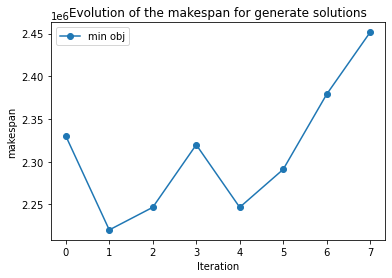

In [10]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[2330208, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240]


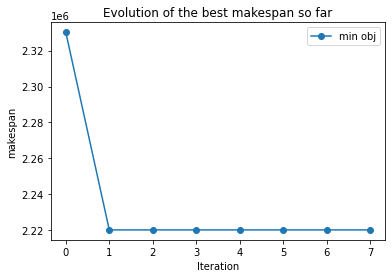

In [11]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [12]:
####################################################################
#### Exploitation: RECHERCHE DE NOUVELLES SOLUTIONS 
####################################################################

import clustering as cl

###  -------------- Iteration of the solver with the preferences
k_k = 4

criterion = (tps < tps_max) and (it < it_max) 
# ----------------- Add the preferences to the model
while criterion :
    print("\n--------Iteration {}---------".format(it))
    it += 1

    # --------- Call Solver constructor in Solver.py and create the variables of the model
    model, solver, starts = fm.initialize_solver(data, n, m, duration)

    # --------- Add the new constraints to the model (that solution must be different from the previous generated solutions)
    variables = fm.update_variables_new_constraint(n, m,  pref, model, solver)
    
    # # --------- Add the constraints considering the clustering
    
    list_rayon_layers, list_start_sol_layers, dict_sol_rayon  = fm.list_rayon_binaire_cluster(n, m, list_layers)
    
    list_cluster_layers = fm.my_clustering_binaire(n, m, list_rayon_layers, list_layers)

    list_centroides_layers = fm.centroides_clusters(n, m, list_cluster_layers)

    sum = 0
    for i in range(len(list_centroides_layers)): #On parcourt les layers
        sum_temp = 0
        for j in range(len(list_centroides_layers[i])): #On parcourt les clusters
            sum_temp += fm.manhattan_binaire_distance_contrainte(list_centroides_layers[i][j], [model.start_of(variables[i//m][i%m]) for i in range(n*m)])
        sum_temp *= len(list_centroides_layers)-i 
        sum += sum_temp
    model.add(minimize(sum))

   

    # ------------ Solve the model
    print("\nSolving the model...")
    # msol, nb_solution, runtime = solver.solve(model, k_k, n, m, it, T_machine, optimalval, list_search_type[it%4])
    msol, nb_solution, runtime = solver.solve(model, k_k, n, m, T_machine, optimalval, tps_max, it_max)
    print("The number of solutions generated is :",nb_solution)
    list = []
    for sol in msol:
        list.append(user.objectiveFunction(sol)*user.objectiveFunctionRegularity(sol, n, m))

    list_min_obj.append(min(list))
    print("Objective function :", list_min_obj)

    # ------------ Display the result
    fm.display_solution(msol, display_sol)
    print("Model solved !")

    # ---------------- Interaction with the user
    list_indice, list_obj, pref, list_layers, list_equal = fm.user_preferences(msol, user, nb_layers, n, m)
    print("Il y a {} solution(s)".format(len(pref)))

    list_min_obj_global.append(min(list_obj))
    print("Objective function global :", list_min_obj_global)

    # Vector of the start time of each task of each preference
    starts = user.start_pref(n, m, display_start)

    # Matrix of the start time of each task of each preference
    matrix = user.matrix_pref(n, m, display_matrix)

    # Testing the order of preferences and the differences between solutions
    fm.test(n, m, user)

#------------------ Condition d'arrêt ------------------
    tps += runtime
    criterion = (tps < tps_max) and (it < it_max) 
    fm.stopCondition(it, it_max, tps, tps_max)



--------Iteration 8---------

Creating the model variables...
Model tasks_by_jobs created !

Solver initialized !

Solving the model...

Adding precedence constraints to the solver...
Precedence constraints added !

Adding disjunctive constraints to the solver...
Disjunctive constraints added !
The number of solutions generated is : 7
Objective function : [2330208, 2220240, 2246688, 2319900, 2246688, 2291088, 2379000, 2451584, 2252412]
Model solved !

Classing solutions...
Le min de list_obj est 2220240
Le max de list_obj est 4248612
Solutions classed !

Creating preferences...
Preferences created !
Il y a 129 solution(s)
Objective function global : [2330208, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240]

Testing order of preferences...
	L'ordre des préférences n'est pas cohérente

Testing differences between solutions...
	Toutes les solutions sont différentes

--------Iteration 9---------

Creating the model variables...
Model tasks_by_jobs created !

Solver

[2330208, 2220240, 2246688, 2319900, 2246688, 2291088, 2379000, 2451584, 2252412, 2258432, 2249600, 2506240, 2202144, 2499868, 2204928]


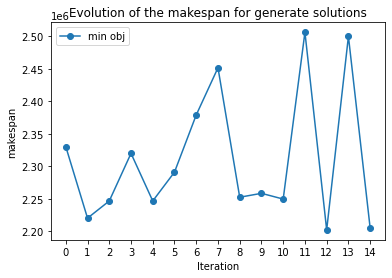

In [13]:
# Plot du minimum de l'objectif parmis les nouvelles solutions générées

import matplotlib.pyplot as plt
print(list_min_obj)
plt.plot([i for i in range(it)], list_min_obj, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the makespan for generate solutions")
plt.xticks(range(it))
plt.legend()
plt.show() 

[2330208, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2220240, 2202144, 2202144, 2202144]


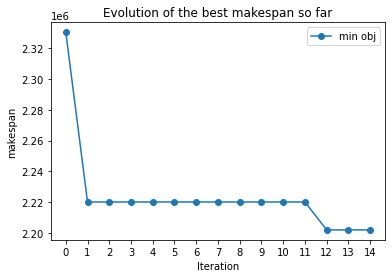

In [14]:
# Plot du minimum de l'objectif parmis les solutions générées so far

print(list_min_obj_global)
plt.plot([i for i in range(it)], list_min_obj_global, label='min obj', marker='o')
plt.xlabel("Iteration")
plt.ylabel("makespan")
plt.title("Evolution of the best makespan so far")
plt.xticks(range(it))
plt.legend()
plt.show() 

In [15]:
# print(len(list_layers)) #nb layer
# print(len(list_cluster_layers[0])) #nb cluster du layer 0
# print(len(list_cluster_layers[0][0])) #nb sol du cluster 0 du layer 0

# list_layers #nb layer
# print(len(list_layers[0])) #nb cluster du layer 0

# n=0
# sol_per_layer = []

# for i in range(len(list_cluster_layers)):
#     nb=0
#     for j in range(len(list_cluster_layers[i])):
        
#         for k in range(len(list_cluster_layers[i][j])):
#             n+=1
#             nb+=1
#     sol_per_layer.append(nb)
# print(n)

# m=0
# sol_per_layer2 = []
# for i in range(len(list_layers)):
#     sol_per_layer2.append(len(list_layers[i]))
#     for j in range(len(list_layers[i])):
#         m+=1


# p=0
# sol_per_layer3 = []
# for i in range(len(list_rayon_layers)):
#     sol_per_layer3.append(len(list_rayon_layers[i]))
#     for j in range(len(list_rayon_layers[i])):
#         p+=1
# print(n)
# print(p)
# print(m)
# print(sol_per_layer)
# print(sol_per_layer2)
# print(sol_per_layer3)

In [16]:
# #flatten list_cluster_layers[0]
# list_cluster_layers_flatten = []
# for i in range(len(list_cluster_layers[0])):
#     list_cluster_layers_flatten = list_cluster_layers_flatten + list_cluster_layers[0][i]
# #vérifier si les solutions sont bien différentes
# for i in range(len(list_cluster_layers_flatten)):
#     for j in range(len(list_cluster_layers_flatten)):
#         if i!=j:
#             if (list_cluster_layers_flatten[i] == list_cluster_layers_flatten[j]):
#                 print("erreur")
#                 print(i)
#                 print(j)
        

In [17]:
list_cluster_layers

[[[[<docplex.cp.solution.CpoSolveResult at 0x1d8441d11c0>, 8],
   [<docplex.cp.solution.CpoSolveResult at 0x1d84249a6c0>, 9],
   [<docplex.cp.solution.CpoSolveResult at 0x1d83cb74d40>, 10],
   [<docplex.cp.solution.CpoSolveResult at 0x1d8457b2f40>, 9],
   [<docplex.cp.solution.CpoSolveResult at 0x1d843efbac0>, 7],
   [<docplex.cp.solution.CpoSolveResult at 0x1d8420c02c0>, 6],
   [<docplex.cp.solution.CpoSolveResult at 0x1d843efbb40>, 6],
   [<docplex.cp.solution.CpoSolveResult at 0x1d8407f47c0>, 7],
   [<docplex.cp.solution.CpoSolveResult at 0x1d83d1e2640>, 9],
   [<docplex.cp.solution.CpoSolveResult at 0x1d83cec21c0>, 10],
   [<docplex.cp.solution.CpoSolveResult at 0x1d843efbd40>, 6],
   [<docplex.cp.solution.CpoSolveResult at 0x1d8420c06c0>, 8],
   [<docplex.cp.solution.CpoSolveResult at 0x1d843efb040>, 7],
   [<docplex.cp.solution.CpoSolveResult at 0x1d849cf7e40>, 3],
   [<docplex.cp.solution.CpoSolveResult at 0x1d843f06bc0>, 11],
   [<docplex.cp.solution.CpoSolveResult at 0x1d84415